In [16]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

import numpy as np
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor

In [145]:
transform = Compose([ToTensor()])
# dataset = MNIST('dataset/', train=True, transform=transform, download=True)
dataset = CIFAR10('dataset/', train=True, transform=transform, download=True)

loader = DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [148]:
len(dataset)

50000

In [18]:
x,y = next(iter(loader))
x.shape

torch.Size([64, 3, 32, 32])

In [24]:
import AttentionMap

model = nn.Sequential(*[
    nn.Conv2d(3, 4, kernel_size=3, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    AttentionMap.Conv2d(4, 12, kernel_size=3, padding=1),
    nn.BatchNorm2d(12),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(start_dim=1),
    # nn.Linear(588, 128), # MNIST
    nn.Linear(8*8*12, 128), # CIFAR
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 10),
    # nn.LogSoftmax(dim=1)
])

In [25]:
from tqdm import tqdm

n_epoch = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(loader):
        input = input.to(device)
        target = target.to(device)

        out = model(input)
        loss = criterion(out, target)

        if idx % 500 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 3/3 [00:34<00:00, 11.46s/epoch, tls=1.2466]


In [42]:
input_lvl3 = model[:4](input.to(device))
am = model[4]
att = am.attention_map(input_lvl3.to(device))[0].detach().cpu()
conv = am.conv(input_lvl3.to(device))[0].detach().cpu()
result = am(input_lvl3.to(device))[0].detach().cpu()

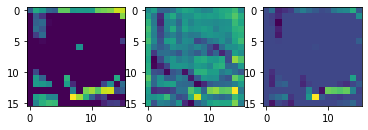

In [43]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,3)
ax[0].imshow(att[0].detach().cpu())
ax[1].imshow(conv[0].detach().cpu())
ax[2].imshow(result[0].detach().cpu())
plt.show()

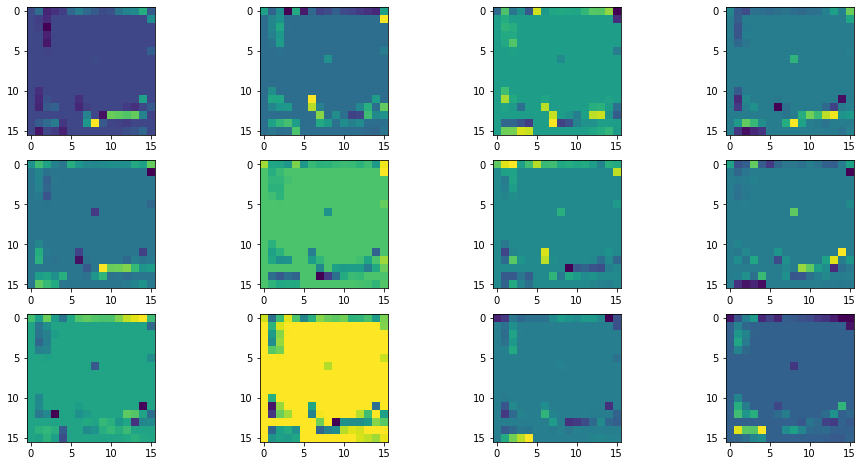

In [44]:
fig, ax = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(result[(i*4)+j])

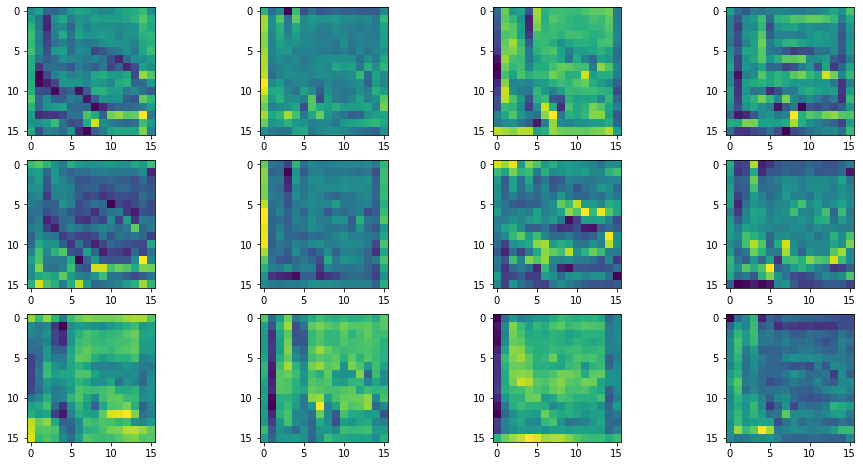

In [45]:
fig, ax = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(conv[(i*4)+j])

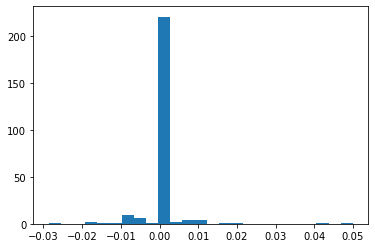

In [30]:
plt.hist(result[0].detach().cpu().flatten().numpy(), bins=25)
plt.show()

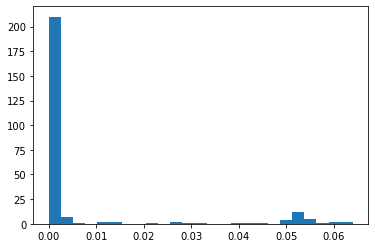

In [31]:
plt.hist(att[0].cpu().flatten().detach().numpy(), bins=25)
plt.show()

In [38]:
model_2 = nn.Sequential(*[
    nn.Conv2d(3, 4, kernel_size=3, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(4, 12, kernel_size=3, padding=1),
    nn.BatchNorm2d(12),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(start_dim=1),
    # nn.Linear(588, 128), # MNIST
    nn.Linear(8*8*12, 128), # CIFAR
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 10),
    # nn.LogSoftmax(dim=1)
])

In [39]:
from tqdm import tqdm

n_epoch = 3
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_2 = model_2.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(loader):
        input = input.to(device)
        target = target.to(device)

        out = model_2(input)
        loss = criterion(out, target)

        if idx % 500 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 3/3 [00:28<00:00,  9.52s/epoch, tls=1.1004]


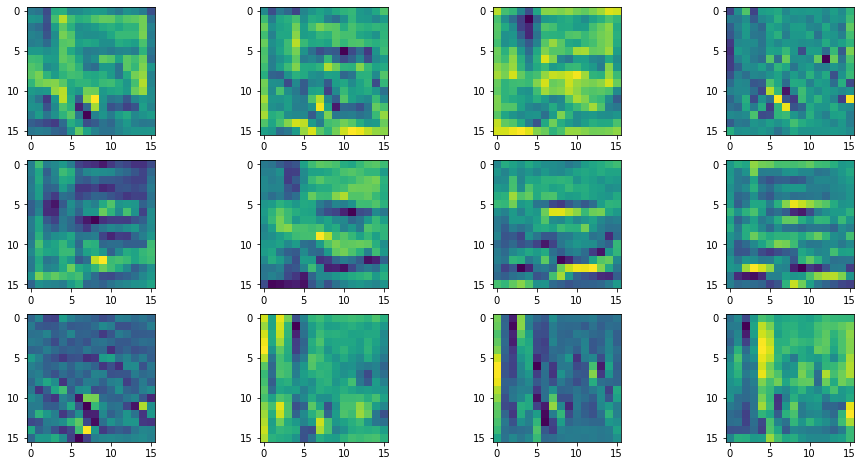

In [40]:
input_lvl3 = model_2[:4](input.to(device))
am = model_2[4]
result = am(input_lvl3.to(device))[0].detach().cpu()

fig, ax = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(result[(i*4)+j])

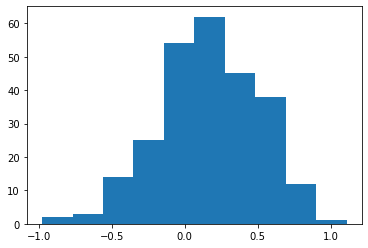

In [41]:
plt.hist(result[0].detach().cpu().flatten().numpy())
plt.show()

In [78]:
l = torch.rand(4, 3, 2, 2)
N,C,W,H = l.shape

c = torch.rand(N, 1, W, H)
a = torch.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)

g = torch.mul(a.expand_as(l), l)

In [97]:
g_0 = g.view(N,C,-1).sum(dim=2)
g_0

tensor([[0.7401, 0.5487, 0.4814],
        [0.3908, 0.5192, 0.3469],
        [0.5391, 0.5205, 0.2754],
        [0.5013, 0.3083, 0.5506]])

In [98]:
g_1 = torch.nn.functional.adaptive_avg_pool2d(g, (1,1)).view(N,C)
g_1

tensor([[0.1850, 0.1372, 0.1203],
        [0.0977, 0.1298, 0.0867],
        [0.1348, 0.1301, 0.0688],
        [0.1253, 0.0771, 0.1377]])

In [110]:
print(g[0][0])
print(g_1[0][0])

tensor([[0.3037, 0.1370],
        [0.1462, 0.1532]])
tensor(0.1850)


In [111]:
class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features, num_conv, pool=False):
        super(ConvBlock, self).__init__()
        features = [in_features] + [out_features for i in range(num_conv)]
        layers = []
        for i in range(len(features)-1):
            layers.append(nn.Conv2d(in_channels=features[i], out_channels=features[i+1], kernel_size=3, padding=1, bias=True))
            layers.append(nn.BatchNorm2d(num_features=features[i+1], affine=True, track_running_stats=True))
            layers.append(nn.ReLU())
            if pool:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.op = nn.Sequential(*layers)
    def forward(self, x):
        return self.op(x)

In [144]:
im_size = 64
test = torch.nn.Sequential(*[
    ConvBlock(3, 64, 2),
    ConvBlock(64, 128, 2),
    ConvBlock(128, 256, 3),
    nn.MaxPool2d(2),
    ConvBlock(256, 512, 3),
    nn.MaxPool2d(2),
    ConvBlock(512, 512, 3),
    nn.MaxPool2d(2),
    ConvBlock(512, 512, 2, pool=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=int(im_size/32), padding=0, bias=True)
])

a = torch.rand(4,3,im_size,im_size)
test[:10](a).shape

torch.Size([4, 512, 1, 1])

In [141]:
im_size/32

2.0

In [143]:
64/32

2.0